In [1]:
import pandas as pd
Outflows = pd.read_parquet("q1-ucsd-outflows.pqt")
inflow = pd.read_parquet('q1-ucsd-inflows.pqt')
outflow = pd.read_parquet('q1-ucsd-outflows.pqt')

outflow_ids = set(outflow["prism_consumer_id"].unique())
inflow_ids = set(inflow["prism_consumer_id"].unique())

# Consumers in inflow but not in outflow
in_not_out = inflow_ids - outflow_ids
out_not_in = outflow_ids - inflow_ids


In [2]:
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import re

In [3]:
#consumers in both inflow and outflow
consumers_both = sorted(set(inflow["prism_consumer_id"]).intersection(outflow["prism_consumer_id"]))

#80-20 train test split
train_ids, test_ids = train_test_split(consumers_both, test_size=0.2, random_state=42)

inflow_train = inflow[inflow["prism_consumer_id"].isin(train_ids)]
inflow_test  = inflow[inflow["prism_consumer_id"].isin(test_ids)]

outflow_train = outflow[outflow["prism_consumer_id"].isin(train_ids)]
outflow_test  = outflow[outflow["prism_consumer_id"].isin(test_ids)]

In [55]:
pd.to_datetime(outflow_train['posted_date'], errors='coerce').iloc[0:10000].apply(lambda x:x.hour).unique()

array([0])

In [4]:
outflow_train[["memo", 'category', 'amount', 'posted_date']].sample(20)

,memo,category,amount,posted_date
526523,CASH APP*ROSS XXXX,GENERAL_MERCHANDISE,100.00,2021-04-19
1780653,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER,19.99,2022-10-03
977797,LAROSA'S MARIEMONT,FOOD_AND_BEVERAGES,43.51,2022-07-25
1830650,MOBILE PURCHASE XXXX THE UPS STORE XXXX XXX-XX...,GENERAL_MERCHANDISE,73.01,2022-01-20
1152764,PURCHASE AUTHORIZED ON 08/03 SP GAMMA ENTERPRI...,GENERAL_MERCHANDISE,38.72,2022-08-05
2557041,DBT CRD XXXX 10/08/22 XXXXXXX STEWARTS SHOP 32...,GENERAL_MERCHANDISE,7.99,2022-10-11
405254,ESSENTIAL_SERVICES,ESSENTIAL_SERVICES,200.00,2022-05-23
997647,AUTOMOTIVE,AUTOMOTIVE,4.77,2022-09-26
2073836,PURCHASE AUTHORIZED ON 07/31 UBER EATS HELP.UB...,TRAVEL,18.32,2022-08-01
433706,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER,2.73,2021-10-22


In [5]:
outflow_train_1 = outflow_train[outflow_train["memo"] != outflow_train["category"]]

outflow_train_1

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
646,2,acc_3,PURCHASE AUTHORIZED ON 03/11 POKE POKU HENDERS...,35.08,2021-03-15,FOOD_AND_BEVERAGES
651,2,acc_3,PURCHASE AUTHORIZED ON 10/01 LIQUOR CITY HENDE...,43.83,2021-10-04,FOOD_AND_BEVERAGES
657,2,acc_3,PURCHASE INTL AUTHORIZED ON 10/20 Rituals Cosm...,98.27,2021-10-21,GENERAL_MERCHANDISE
658,2,acc_3,Trader Joe''s,152.61,2021-04-14,GROCERIES
660,2,acc_3,PURCHASE AUTHORIZED ON 05/28 VANS #174 LAS VEG...,81.17,2021-05-28,GENERAL_MERCHANDISE
...,...,...,...,...,...,...
2597457,5941,acc_9524,DEBIT CARD WITHDRAWAL PURCHASEAmazon Prime*TI4...,15.93,2023-01-16,GENERAL_MERCHANDISE
2597462,5941,acc_9524,POS WITHDRAWALAZ LOT QUIKTRIP XXXX XXXX E INDI...,25.00,2023-01-18,EDUCATION
2597465,5941,acc_9524,POS WITHDRAWALWAL-MART #XXXX XXXX E MCKELLIPS ...,3.68,2023-01-18,FOOD_AND_BEVERAGES
2597468,5941,acc_9524,WITHDRAWAL Salt River ProjeTYPE: ONLINE PMT CO...,90.00,2023-01-20,FOOD_AND_BEVERAGES


/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


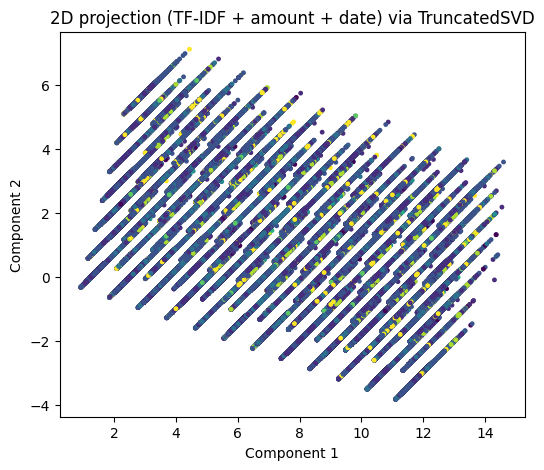

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current pr

Linear separability (logistic regression) accuracy: 0.976529395710941


In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# --- 0) Clean columns ---
df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X = df[['cleaned_memo','amount','posted_date']]
y = df['category']

# --- 1) Feature pipelines ---
# Amount: log1p -> scale
amount_pipe = make_pipeline(
    FunctionTransformer(lambda x: np.log1p(x.astype(float))),
    StandardScaler(with_mean=False)  # keep sparse compatibility
)



def date_features(X):
    # X can be a DataFrame (n,1) or a 2D array (n,1)
    if isinstance(X, pd.DataFrame):
        s = pd.to_datetime(X.iloc[:, 0], errors='coerce')
    else:
        X = np.asarray(X)
        s = pd.to_datetime(pd.Series(X.reshape(-1)), errors='coerce')

    hour = s.dt.hour.fillna(0).astype(int)
    dow  = s.dt.dayofweek.fillna(0).astype(int)   # Monday=0
    mon  = s.dt.month.fillna(0).astype(int)

    return np.column_stack([hour, dow, mon])

date_pipe = FunctionTransformer(date_features, validate=False)

# Text: TF-IDF (char/word choices are tunable)
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))

# --- 2) Column transformer (memo text + amount + date features) ---
pre = ColumnTransformer(
    transformers=[
        ('cleaned_memo', tfidf, 'cleaned_memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop'
)

# --- 3) 2D projection for visualization (TruncatedSVD works on sparse) ---
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(pre.fit_transform(X))

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=pd.Categorical(y).codes, s=6)
plt.title("2D projection (TF-IDF + amount + date) via TruncatedSVD")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.show()

# --- 4) Linear separability diagnostic: logistic regression (linear) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

linear_clf = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=2000, multi_class='ovr', n_jobs=-1))
])
linear_clf.fit(X_train, y_train)
pred = linear_clf.predict(X_test)
print("Linear separability (logistic regression) accuracy:", accuracy_score(y_test, pred))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
device = "mps" if torch.backends.mps.is_available() else "cpu"

df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda" 
else:
    device ="cpu"

# ==== NEW: numeric feature prep (scikit-learn) ====
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load/clean as before
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X_df = df[['memo','amount','posted_date']]
y_str = df['category'].astype(str)

# Label -> int64
le = LabelEncoder()
y_np = le.fit_transform(y_str).astype('int64')

# Date -> [hour, dow, month]
def date_features(Xcol):
    if isinstance(Xcol, pd.DataFrame):
        s = pd.to_datetime(Xcol.iloc[:,0], errors='coerce')
    else:
        Xcol = np.asarray(Xcol)
        s = pd.to_datetime(pd.Series(Xcol.reshape(-1)), errors='coerce')
    dow  = s.dt.dayofweek.fillna(0).astype(int)
    mon  = s.dt.month.fillna(0).astype(int)
    return np.column_stack([dow, mon])

date_pipe = Pipeline([
    ('extract', FunctionTransformer(date_features, validate=False)),
    ('scale', StandardScaler())
])

amount_pipe = make_pipeline(
    FunctionTransformer(lambda a: np.log1p(a.astype(float))),
    StandardScaler()
)

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))),
    ('svd', TruncatedSVD(n_components=128, random_state=42))
])

pre = ColumnTransformer(
    transformers=[
        ('memo', text_pipe, 'memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop',
    sparse_threshold=0.0   # force dense
)

X_np = pre.fit_transform(X_df).astype('float32')   # << numeric features for Torch

# ==== Back to your original Torch code ====
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

# ---- Model ----
class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, hidden_units),
            nn.Linear(hidden_units, output_features)  # raw logits for 9 classes
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=256).to(device)

# ---- Loss/Optimizer ----
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# ---- Train ----
model.train()
for epoch in range(10):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f"epoch {epoch+1}: loss {total_loss/len(loader):.4f}")

# ---- Evaluate ----
model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)

acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


Accuracy: 0.8095


In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Device (safe fallback) ----
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda" 
else:
    device ="cpu"

# ==== NEW: numeric feature prep (scikit-learn) ====
import numpy as np
import pandas as pd
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Load/clean as before
df = outflow_train_1.dropna(subset=['cleaned_memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

X_df = df[['cleaned_memo','amount','posted_date']]
y_str = df['category'].astype(str)

# Label -> int64
le = LabelEncoder()
y_np = le.fit_transform(y_str).astype('int64')

# Date -> [hour, dow, month]
def date_features(Xcol):
    if isinstance(Xcol, pd.DataFrame):
        s = pd.to_datetime(Xcol.iloc[:,0], errors='coerce')
    else:
        Xcol = np.asarray(Xcol)
        s = pd.to_datetime(pd.Series(Xcol.reshape(-1)), errors='coerce')
    dow  = s.dt.dayofweek.fillna(0).astype(int)
    mon  = s.dt.month.fillna(0).astype(int)
    return np.column_stack([dow, mon])

date_pipe = Pipeline([
    ('extract', FunctionTransformer(date_features, validate=False)),
    ('scale', StandardScaler())
])

amount_pipe = make_pipeline(
    FunctionTransformer(lambda a: np.log1p(a.astype(float))),
    StandardScaler()
)

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_df=0.95, ngram_range=(1,5))),
    ('svd', TruncatedSVD(n_components=128, random_state=42))
])

pre = ColumnTransformer(
    transformers=[
        ('cleaned_memo', text_pipe, 'cleaned_memo'),
        ('amount', amount_pipe, ['amount']),
        ('date', date_pipe, ['posted_date']),
    ],
    remainder='drop',
    sparse_threshold=0.0   # force dense
)

X_np = pre.fit_transform(X_df).astype('float32')   # << numeric features for Torch

# ==== Back to your original Torch code ====
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

# ---- Model ----
class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)  # raw logits for 9 classes
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=256).to(device)

# ---- Loss/Optimizer ----
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# ---- Train ----
model.train()
for epoch in range(10):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # print(f"epoch {epoch+1}: loss {total_loss/len(loader):.4f}")

# ---- Evaluate ----
model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)

acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: divide by zero encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: overflow encountered in matmul
  U = Q @ Uhat
/Users/kylechoi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:547: RuntimeWarning: invalid value encountered in matmul
  U = Q @ Uhat


Accuracy: 0.8189


In [ ]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")

# 2) Build your feature matrix: [embedding | log1p(amount) | hour | dow | month]
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

memo_emb = embed_text(df['memo'].astype(str).tolist())            # shape [N, D]

amt = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
mon  = df['posted_date'].dt.month.to_numpy()[:, None]

num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")

X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")
# y to int64
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# 3) Back to your original Torch code (no change below this line)
import torch.nn.functional as F
X_t = torch.from_numpy(X_np).to(device)
y_t = torch.from_numpy(y_np).to(device)

dataset = torch.utils.data.TensorDataset(X_t, y_t)
loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)

class Categorio_V1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=128):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model = Categorio_V1(input_features=X_np.shape[1], output_features=9, hidden_units=128).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

model.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

model.eval()
with torch.inference_mode():
    logits = model(X_t)
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8867


In [14]:
model.state_dict()

OrderedDict([('linear_layer_stack.0.weight',
              tensor([[-0.0206,  0.0204,  0.0498,  ...,  0.0459, -0.0405, -0.2095],
                      [ 0.0277, -0.0336,  0.0055,  ..., -0.0286, -0.0412, -0.0900],
                      [ 0.0130, -0.0593, -0.0560,  ..., -0.0096, -0.0084, -0.2692],
                      ...,
                      [ 0.0181, -0.0342, -0.0217,  ...,  0.0073, -0.0117, -0.0326],
                      [ 0.0462, -0.0442, -0.0384,  ..., -0.0129, -0.0063, -0.0127],
                      [-0.1348,  0.0527, -0.0928,  ...,  0.0424, -0.2031, -0.5905]],
                     device='mps:0')),
             ('linear_layer_stack.0.bias',
              tensor([ 1.1427e-01,  2.1050e-02,  1.4764e-01, -4.7979e-02,  1.0945e+00,
                      -4.2933e-02,  3.5479e-02,  4.8629e-02, -2.1047e-02, -1.9654e-01,
                       3.2143e+00, -2.3350e-02,  9.8858e-02,  8.0273e-02, -6.1109e-01,
                       3.7528e-03, -3.4043e-02, -2.8984e-02,  5.6175e-02,  5.902

In [81]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")

# 2) Build your feature matrix: [embedding | log1p(amount) | dow | month]
df = outflow_train_1.dropna(subset=['memo','category','amount','posted_date']).copy()
df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
df = df.dropna(subset=['posted_date'])

memo_emb = embed_text(df['memo'].astype(str).tolist())            # shape [N, D]
amt = np.log1p(df['amount'].astype(float).to_numpy())[:, None]
dow  = df['posted_date'].dt.dayofweek.to_numpy()[:, None]
mon  = df['posted_date'].dt.month.to_numpy()[:, None]
num_feats = np.concatenate([amt, dow, mon], axis=1).astype("float32")

X_np = np.concatenate([memo_emb, num_feats], axis=1).astype("float32")

# y to int64
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_np = le.fit_transform(df['category'].astype(str)).astype("int64")

# --- NEW: simple train/val split for the meta loop ---
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.1, random_state=42, stratify=y_np
)

# 3) Back to your original Torch code (no change below this line, except meta bits)
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

X_t = torch.from_numpy(X_train).to(device)
y_t = torch.from_numpy(y_train).to(device)
Xv_t = torch.from_numpy(X_val).to(device)
yv_t = torch.from_numpy(y_val).to(device)

train_ds = torch.utils.data.TensorDataset(X_t, y_t)
val_ds   = torch.utils.data.TensorDataset(Xv_t, yv_t)

loader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=512, shuffle=True)

class Categorio_V3(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)

model_3 = Categorio_V3(d_in=X_np.shape[1], d_out=len(le.classes_), width=512, p=0.2).to(device)
optimizer = torch.optim.AdamW(model_3.parameters(), lr=1e-3, weight_decay=1e-4)
# Compute class weights (inverse frequency)
classes, counts = np.unique(y_np, return_counts=True)
class_weights = torch.tensor(1.0 / counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(classes)  # normalize

# Move to device
class_weights = class_weights.to(device)

# Use in your loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# --- NEW: helper to get a small validation minibatch iterator ---
import itertools
val_iter = itertools.cycle(val_loader)  # endless cycle of validation mini-batches

# --- NEW: one-step "probe" update to estimate validation effect of the current batch ---
@torch.no_grad()
def eval_val_loss(m, xv, yv):
    m.eval()
    logits_v = m(xv)
    return loss_fn(logits_v, yv).detach()

def meta_weight_for_batch(model, xb, yb, xv, yv, inner_lr=5e-4, sharpness=10.0):
    """
    Make a fast copy of the model, apply one SGD-like step on (xb, yb),
    then measure Δval = L_after - L_before. Convert to weight via sigmoid(-sharpness * Δval).
    """
    # 1) measure validation loss before
    with torch.no_grad():
        val_before = eval_val_loss(model, xv, yv)

    # 2) clone parameters (cheap state_dict copy)
    probe = deepcopy(model).to(device)
    probe.train()
    # manual one-step update on probe (SGD-style, not AdamW) to keep it light
    probe.zero_grad(set_to_none=True)
    logits = probe(xb)
    train_loss = loss_fn(logits, yb)
    grads = torch.autograd.grad(train_loss, probe.parameters(), create_graph=False)
    with torch.no_grad():
        for p, g in zip(probe.parameters(), grads):
            if g is not None:
                p.add_( -inner_lr * g )

    # 3) measure validation loss after the hypothetical update
    with torch.no_grad():
        val_after = eval_val_loss(probe, xv, yv)

    # 4) convert improvement into a weight in (0,1): improve -> weight ~ 1, hurt -> weight ~ 0
    delta = (val_after - val_before).clamp(min=-5.0, max=5.0)  # tame outliers
    w = torch.sigmoid(-sharpness * delta).item()
    return float(w)

# --- Training with meta-weighted batch losses ---
model_3.train()
for epoch in range(20):
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        xv, yv = next(val_iter)
        xv = xv.to(device); yv = yv.to(device)

        # Compute a meta-derived weight for THIS batch (cheap, 1-step unroll)
        w_batch = meta_weight_for_batch(model_3, xb, yb, xv, yv, inner_lr=5e-4, sharpness=10.0)

        optimizer.zero_grad(set_to_none=True)
        logits = model_3(xb)
        loss = loss_fn(logits, yb)
        # --- NEW: scale the actual update by the meta weight ---
        (loss * w_batch).backward()
        optimizer.step()

        total_loss += loss.item()

# Final evals
model_3.eval()
with torch.inference_mode():
    logits_tr = model_3(X_t)
    preds_tr = logits_tr.argmax(dim=1)
    acc_tr = (preds_tr == y_t).float().mean().item()

    logits_va = model_3(Xv_t)
    preds_va = logits_va.argmax(dim=1)
    acc_va = (preds_va == yv_t).float().mean().item()

print(f"Train accuracy: {acc_tr:.4f} | Val accuracy: {acc_va:.4f}")

Train accuracy: 0.9637 | Val accuracy: 0.9567


In [35]:
import torch, joblib, numpy as np

torch.save({
    "state_dict": model_2.state_dict(),
    "d_in": X_np.shape[1],
    "width": 512,
    "p": 0.2,
    "classes": le.classes_.tolist(),
}, "categorio_v2.pt")

joblib.dump(le, "label_encoder.pkl")
print("Saved model to categorio_v2.pt and encoder to label_encoder.pkl")

Saved model to categorio_v2.pt and encoder to label_encoder.pkl


In [82]:
import torch, joblib, numpy as np

torch.save({
    "state_dict": model_3.state_dict(),
    "d_in": X_np.shape[1],
    "width": 512,
    "p": 0.2,
    "classes": le.classes_.tolist(),
}, "categorio_v3.pt")

joblib.dump(le, "label_encoder.pkl")
print("Saved model to categorio_v3.pt and encoder to label_encoder.pkl")

Saved model to categorio_v3.pt and encoder to label_encoder.pkl


In [ ]:
import torch, joblib, numpy as np
# Recreate your class
class Categorio_V2(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)

device = "mps" if torch.backends.mps.is_available() else "cpu"

state = torch.load("categorio_v2.pt", map_location=device)
le = joblib.load("label_encoder.pkl")

model_2 = Categorio_V2(
    d_in=state["d_in"],
    d_out=len(state["classes"]),
    width=state.get("width", 512),
    p=state.get("p", 0.2),
).to(device)
model_2.load_state_dict(state["state_dict"])

# ensure LabelEncoder has same classes (needed if you didn't load joblib)
le.classes_ = np.array(state["classes"])
model_2.eval()

Categorio_V2(
  (net): Sequential(
    (0): Linear(in_features=387, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=9, bias=True)
  )
)

In [83]:
import torch, joblib, numpy as np
# Recreate your class
class Categorio_V3(nn.Module):
    def __init__(self, d_in, d_out, width=512, p=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, width), nn.ReLU(), nn.Dropout(p),
            nn.Linear(width, d_out)
        )
    def forward(self, x): return self.net(x)

device = "mps" if torch.backends.mps.is_available() else "cpu"

state = torch.load("categorio_v3.pt", map_location=device)
le = joblib.load("label_encoder.pkl")

model_3 = Categorio_V3(
    d_in=state["d_in"],
    d_out=len(state["classes"]),
    width=state.get("width", 512),
    p=state.get("p", 0.2),
).to(device)
model_3.load_state_dict(state["state_dict"])

# ensure LabelEncoder has same classes (needed if you didn't load joblib)
le.classes_ = np.array(state["classes"])
model_3.eval()

Categorio_V3(
  (net): Sequential(
    (0): Linear(in_features=387, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out_features=9, bias=True)
  )
)

In [58]:
le.classes_

array(['EDUCATION', 'FOOD_AND_BEVERAGES', 'GENERAL_MERCHANDISE',
       'GROCERIES', 'MORTGAGE', 'OVERDRAFT', 'PETS', 'RENT', 'TRAVEL'],
      dtype='<U19')

In [39]:
outflow_test_1 = outflow_test[outflow_test['memo'] != outflow_test['category']]

In [ ]:
# 1) Embed memos with a local transformer (no fine-tuning)
from transformers import AutoTokenizer, AutoModel
import torch, numpy as np, pandas as pd

device = "mps" if torch.backends.mps.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
enc = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device).eval()
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    return (last_hidden_state * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

@torch.no_grad()
def embed_text(texts, batch_size=256):
    outs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        m = enc(**t)
        emb = mean_pool(m.last_hidden_state, t["attention_mask"])  # [B, D]
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)       # (optional)
        outs.append(emb.cpu())
    return torch.cat(outs, dim=0).numpy().astype("float32")
X_te_np, y_te_txt, df_te = build_features(outflow_test_1)


Test Accuracy: 0.9093


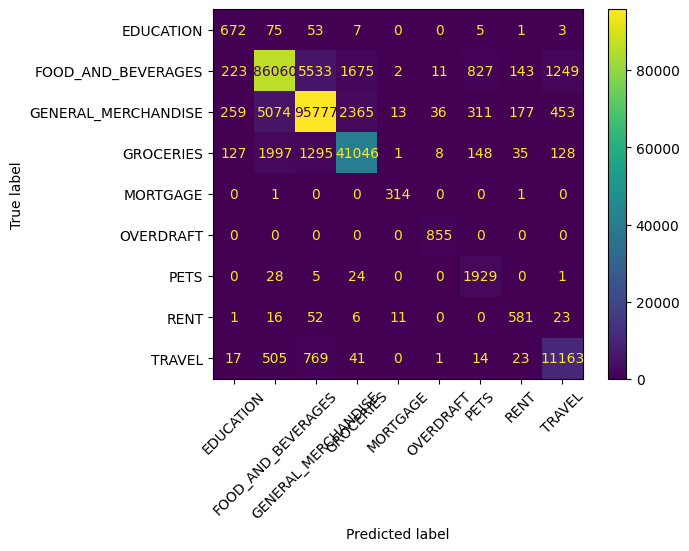

<Figure size 2000x3000 with 0 Axes>

In [76]:

# Filter unseen labels (or map to 'other' if you add such a class)
mask_known = np.isin(y_te_txt, le.classes_)
if not mask_known.all():
    unknown_ct = (~mask_known).sum()
    print(f"Filtered {unknown_ct} rows with unseen categories in test.")
X_te_np = X_te_np[mask_known]
y_te_txt = y_te_txt[mask_known]

y_te_np = le.transform(y_te_txt).astype("int64")
X_te = torch.from_numpy(X_te_np).to(device)
y_te = torch.from_numpy(y_te_np).to(device)

model_2.eval()
with torch.inference_mode():
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model_2(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If preds and y_te are torch tensors of class indices:
y_true = y_te.detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()

# If they’re integer-encoded (LabelEncoder), labels should be 0..n-1:
labels_idx = np.arange(len(le.classes_))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

# Nice labeled plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, colorbar=True)
plt.figure(figsize=(20,30))
plt.tight_layout()
plt.show()

Test Accuracy: 0.9110


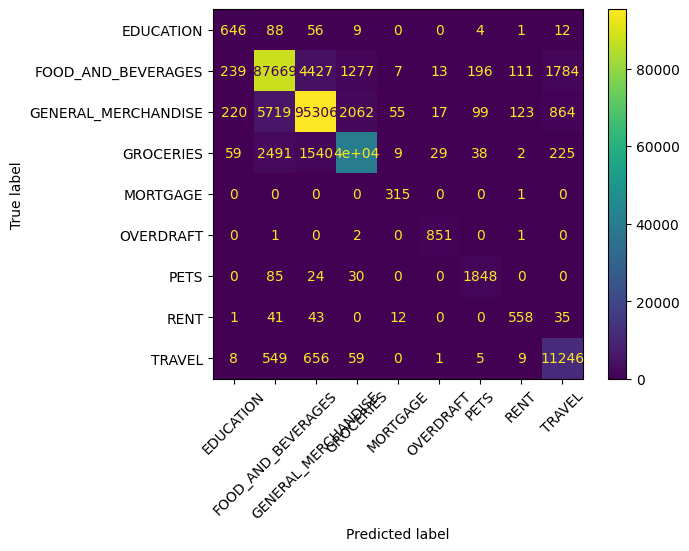

<Figure size 2000x3000 with 0 Axes>

In [87]:
# Filter unseen labels (or map to 'other' if you add such a class)
mask_known = np.isin(y_te_txt, le.classes_)
if not mask_known.all():
    unknown_ct = (~mask_known).sum()
    print(f"Filtered {unknown_ct} rows with unseen categories in test.")
X_te_np = X_te_np[mask_known]
y_te_txt = y_te_txt[mask_known]

y_te_np = le.transform(y_te_txt).astype("int64")
X_te = torch.from_numpy(X_te_np).to(device)
y_te = torch.from_numpy(y_te_np).to(device)

model_3.eval()
with torch.inference_mode():
    bs = 1024
    preds_list = []
    for i in range(0, X_te.shape[0], bs):
        logits = model_3(X_te[i:i+bs])
        preds_list.append(logits.argmax(dim=1))
    preds = torch.cat(preds_list)

test_acc = (preds == y_te).float().mean().item()
print(f"Test Accuracy: {test_acc:.4f}")


import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If preds and y_te are torch tensors of class indices:
y_true = y_te.detach().cpu().numpy()
y_pred = preds.detach().cpu().numpy()

# If they’re integer-encoded (LabelEncoder), labels should be 0..n-1:
labels_idx = np.arange(len(le.classes_))
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)

# Nice labeled plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45, colorbar=True)
plt.figure(figsize=(20,30))
plt.tight_layout()
plt.show()

Overall
  accuracy:      0.9093
  macro F1:      0.8465
  weighted F1:   0.9101
  log loss:      0.2749
  top3_acc:        0.9940

Per-class report
                     precision    recall  f1-score   support

          EDUCATION       0.52      0.82      0.64       816
 FOOD_AND_BEVERAGES       0.92      0.90      0.91     95723
GENERAL_MERCHANDISE       0.93      0.92      0.92    104465
          GROCERIES       0.91      0.92      0.91     44785
           MORTGAGE       0.92      0.99      0.96       316
          OVERDRAFT       0.94      1.00      0.97       855
               PETS       0.60      0.97      0.74      1987
               RENT       0.60      0.84      0.70       690
             TRAVEL       0.86      0.89      0.87     12533

           accuracy                           0.91    262170
          macro avg       0.80      0.92      0.85    262170
       weighted avg       0.91      0.91      0.91    262170



<Figure size 1400x1200 with 0 Axes>

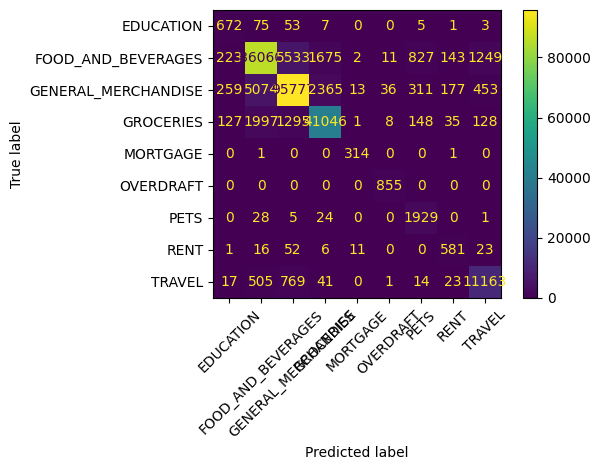

Overall
  accuracy:      0.9170
  macro F1:      0.8728
  weighted F1:   0.9173
  log loss:      0.3007
  top3_acc:        0.9956

Per-class report
                     precision    recall  f1-score   support

          EDUCATION       0.52      0.78      0.62       816
 FOOD_AND_BEVERAGES       0.91      0.92      0.92     95723
GENERAL_MERCHANDISE       0.94      0.92      0.93    104465
          GROCERIES       0.91      0.92      0.91     44785
           MORTGAGE       0.90      0.99      0.95       316
          OVERDRAFT       0.93      1.00      0.97       855
               PETS       0.85      0.95      0.90      1987
               RENT       0.78      0.81      0.80       690
             TRAVEL       0.86      0.88      0.87     12533

           accuracy                           0.92    262170
          macro avg       0.85      0.91      0.87    262170
       weighted avg       0.92      0.92      0.92    262170



<Figure size 1400x1200 with 0 Axes>

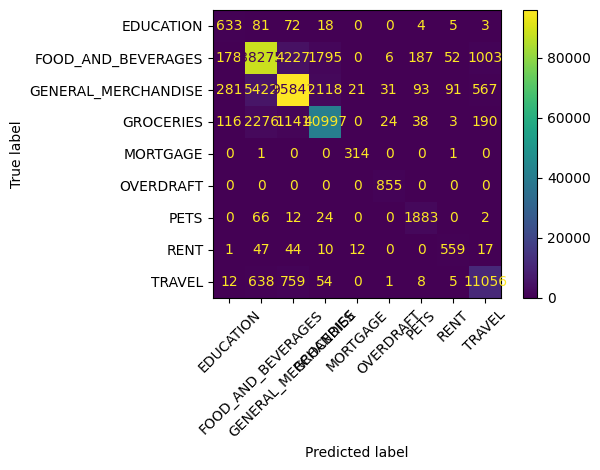


Summary:
         acc | model_2: 0.9093 | model_3: 0.9170
    f1_macro | model_2: 0.8465 | model_3: 0.8728
 f1_weighted | model_2: 0.9101 | model_3: 0.9173
    log_loss | model_2: 0.2749 | model_3: 0.3007
    top3_acc | model_2: 0.9940 | model_3: 0.9956


In [79]:
import numpy as np, torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    log_loss, top_k_accuracy_score
)
import matplotlib.pyplot as plt

def predict_logits(model, X_te, bs=1024):
    model.eval()
    outs = []
    with torch.inference_mode():
        for i in range(0, X_te.shape[0], bs):
            outs.append(model(X_te[i:i+bs]))
    return torch.cat(outs)

def evaluate_model(model, X_te, y_te, label_names=None, topk=(3,)):
    logits = predict_logits(model, X_te)
    probs  = torch.softmax(logits, dim=1).cpu().numpy()
    preds  = probs.argmax(axis=1)
    y_true = y_te.detach().cpu().numpy()

    acc = accuracy_score(y_true, preds)
    f1_macro    = f1_score(y_true, preds, average="macro")
    f1_weighted = f1_score(y_true, preds, average="weighted")
    ll = log_loss(y_true, probs, labels=np.arange(probs.shape[1]))

    topk_accs = {}
    for k in topk:
        topk_accs[f"top{k}_acc"] = top_k_accuracy_score(y_true, probs, k=k)

    print("Overall")
    print(f"  accuracy:      {acc:.4f}")
    print(f"  macro F1:      {f1_macro:.4f}")
    print(f"  weighted F1:   {f1_weighted:.4f}")
    print(f"  log loss:      {ll:.4f}")
    for k, v in topk_accs.items():
        print(f"  {k}:        {v:.4f}")

    print("\nPer-class report")
    print(classification_report(y_true, preds, target_names=label_names) if label_names is not None
          else classification_report(y_true, preds))

    # Confusion matrix (optional)
    cm = confusion_matrix(y_true, preds, labels=np.arange(probs.shape[1]))
    plt.figure(figsize=(14, 12))
    ConfusionMatrixDisplay(cm, display_labels=label_names).plot(xticks_rotation=45, colorbar=True)
    plt.tight_layout()
    plt.show()

    return {"acc": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted, "log_loss": ll, **topk_accs,
            "preds": preds, "probs": probs}

# --- Run both ---
names = le.classes_.tolist()
res2 = evaluate_model(model_2, X_te, y_te, label_names=names, topk=(3,))
res3 = evaluate_model(model_3, X_te, y_te, label_names=names, topk=(3,))

print("\nSummary:")
for k in ["acc", "f1_macro", "f1_weighted", "log_loss", "top3_acc"]:
    print(f"{k:>12s} | model_2: {res2[k]:.4f} | model_3: {res3[k]:.4f}")